### Import Necessary Libraries

In [19]:
import os
import re
import torch
import numpy as np 
from tqdm import tqdm
import torch.nn as nn 
import seaborn as sns
from torchvision import models
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from skimage.metrics import mean_squared_error, structural_similarity as SSIM

### Gather Image Dataset

In [2]:
dataset_dir = "Dataset"
lr_img_path, hr_img_path = os.path.join(dataset_dir, "LR"), os.path.join(dataset_dir, "HR")

lr_img_contents = sorted(os.listdir(lr_img_path), key=lambda file: list(map(int, re.findall(r'\d+', file)))[0])
hr_img_contents = sorted(os.listdir(hr_img_path), key=lambda file: list(map(int, re.findall(r'\d+', file)))[0])

lr, hr = [], []
for i in range(len(lr_img_contents)):
    lr.append(np.load(os.path.join(lr_img_path, lr_img_contents[i])))
    hr.append(np.load(os.path.join(hr_img_path, hr_img_contents[i])))

lr_numpy, hr_numpy = np.array(lr), np.array(hr)
img_LR_tensor, img_HR_tensor = torch.tensor(lr_numpy, dtype=torch.float32), torch.tensor(hr_numpy, dtype=torch.float32)

### Train-Test Split, TensorDataset, Dataloader

In [3]:
LR_train, LR_test, HR_train, HR_test = train_test_split(img_LR_tensor, img_HR_tensor, test_size=0.1)

trainDataset = TensorDataset(LR_train, HR_train)
batchSize = 16
trainLoader = DataLoader(trainDataset, batch_size=batchSize, shuffle=True)

testDataset = TensorDataset(LR_test, HR_test)
testLoader = DataLoader(testDataset, batch_size=batchSize)

### Example plot

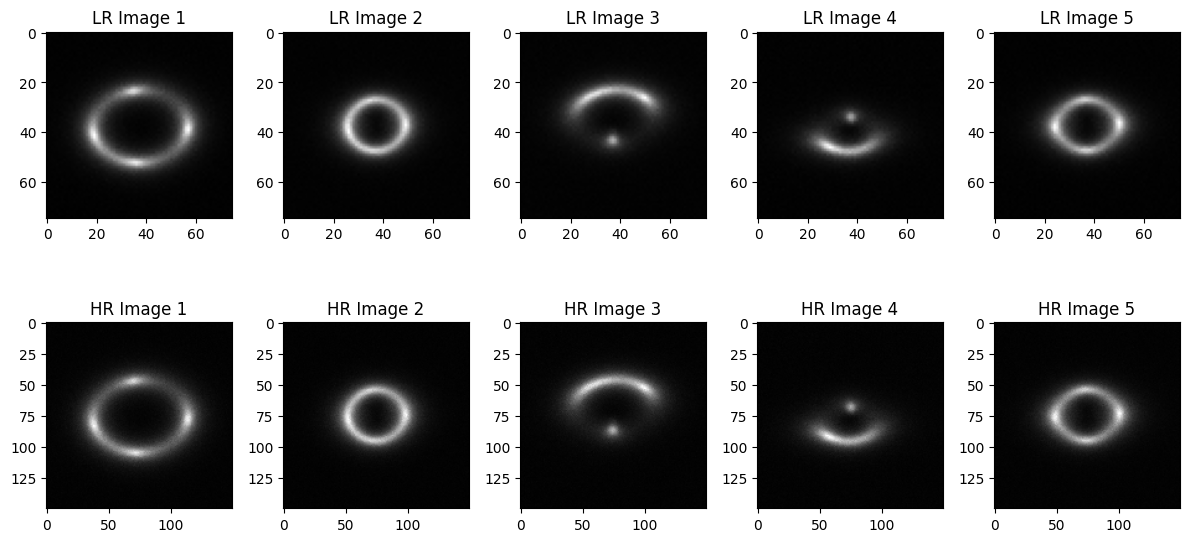

In [4]:
X, y = next(iter(trainLoader))
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(5):
    ax[0, i].imshow(X[i].squeeze(0), cmap="gray")
    ax[0, i].set_title(f"LR Image {i+1}")
    ax[1, i].imshow(y[i].squeeze(0), cmap="gray")
    ax[1, i].set_title(f"HR Image {i+1}")
plt.tight_layout()
plt.show()

### PSNR Function

In [5]:
def PSNR(ground_truth, predicted):
    mse = np.mean((ground_truth - predicted)**2)
    if (mse == 0):
        return 100
    max_pixel = 1.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

### Networks

In [6]:
# NOTE: Architecture from paper https://arxiv.org/pdf/1603.08155

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv(out)
        return out 

class UpsampleConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        if upsample:
            self.upsample = nn.Upsample(scale_factor=upsample, mode="nearest")
        reflection_padding = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(reflection_padding)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
    
    def forward(self, x):
        if self.upsample:
            x = self.upsample(x)
        out = self.reflection_pad(x)
        out = self.conv(out)
        return out

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = nn.InstanceNorm2d(channels, affine=True)
        self.relu = nn.ReLU()
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = nn.InstanceNorm2d(channels, affine=True)
    
    def forward(self, x):
        residual = x 
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        out = self.relu(out)
        return out

class ImageTransformNet(nn.Module):
    def __init__(self):
        super(ImageTransformNet, self).__init__()
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.conv1 = ConvLayer(in_channels=1, out_channels=32, kernel_size=9, stride=1)
        self.in1_e = nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(in_channels=32, out_channels=64, kernel_size=3, stride=2)
        self.in2_e = nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(in_channels=64, out_channels=128, kernel_size=3, stride=2)
        self.in3_e = nn.InstanceNorm2d(128, affine=True)
     
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)

        self.deconv3 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in3_d = nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in2_d = nn.InstanceNorm2d(32, affine=True)
        self.deconv1 = UpsampleConvLayer(32, 32, kernel_size=9, stride=1, upsample=2)
        self.in1_d = nn.InstanceNorm2d(32, affine=True)

        self.conv4 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=3, stride=1)
    
    def forward(self, x):
        y = self.relu(self.in1_e(self.conv1(x)))
        y = self.relu(self.in2_e(self.conv2(y)))
        y = self.relu(self.in3_e(self.conv3(y)))

        y = self.res1(y)
        y = self.res1(y)
        y = self.res1(y)
        y = self.res1(y)
        y = self.res1(y)

        y = self.relu(self.in3_d(self.deconv3(y)))
        y = self.relu(self.in2_d(self.deconv2(y)))
        y = self.relu(self.in1_d(self.deconv1(y)))
        y = self.sigmoid(self.conv4(y))
        return y

class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = models.vgg16(weights="VGG16_Weights.DEFAULT").features
        features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.to_relu_1_2 = nn.Sequential()
        self.to_relu_2_2 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        
        for param in self.parameters():
            param.requires_grad = False
    
    def forward(self, x):
        h = self.to_relu_1_2(x)
        h = self.to_relu_2_2(h)
        out_relu_2_2 = h
        return out_relu_2_2

### Model, Optimzer, Lossfn Definition

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
alpha = 1e-3
img_transformer = ImageTransformNet().to(device=device)
loss_network = Vgg16().to(device=device)
optimizer = torch.optim.Adam(img_transformer.parameters(), lr=alpha)
mse_loss = nn.MSELoss()

# Model Summary
# summary(model, (1, 75, 75), device=device)

### Train function

In [8]:
RECON_WEIGHT, PIXEL_WEIGHT, TV_WEIGHT = 1e2, 1e2, 1e-7

def trainModel(img_transformer, vgg, mse_loss, optimizer, iteration):
    epochs = iteration

    trainLoss, trainReconLoss, trainPixelLoss, trainTVLoss = [], [], [], []

    iteration_count = 0
    total_iterations = len(trainLoader) * epochs

    with tqdm(total=total_iterations, desc="Training Progress") as pbar:

        for _ in range(epochs):
            img_transformer.train()
            batchLoss, batchReconLoss, batchPixelLoss, batchTVLoss = [], [], [], []

            aggregate_recon_loss = 0.0
            aggregate_pixel_loss = 0.0
            aggregate_tv_loss = 0.0

            for X, y in trainLoader:
                X, y = X.to(device), y.to(device)

                ## input to image transformer network
                yHat = img_transformer(X)

                ## vgg features
                content_features = vgg(y)
                yhat_features = vgg(yHat)

                ## feature recon loss
                recon_loss = RECON_WEIGHT * mse_loss(yhat_features, content_features)
                aggregate_recon_loss += recon_loss.item()
                batchReconLoss.append(recon_loss.item())

                ## per-pixel loss
                pixel_loss = PIXEL_WEIGHT * mse_loss(yHat, y)
                aggregate_pixel_loss += pixel_loss.item()
                batchPixelLoss.append(pixel_loss.item())

                ## tv loss
                diff_i = torch.sum(torch.abs(yHat[:, :, :, 1:] - yHat[:, :, :, :-1]))
                diff_j = torch.sum(torch.abs(yHat[:, :, 1:, :] - yHat[:, :, :-1, :]))
                tv_loss = TV_WEIGHT * (diff_i + diff_j)
                aggregate_tv_loss += tv_loss.item()
                batchTVLoss.append(tv_loss.item())

                ## total loss
                total_loss = recon_loss + pixel_loss + tv_loss

                optimizer.zero_grad()
                total_loss.backward()
                optimizer.step()

                batchLoss.append(total_loss.item())

                iteration_count += 1

                if iteration_count % 200 == 0:
                    avg_train_loss, avg_recon_loss, avg_pixel_loss, avg_tv_loss = np.mean(batchLoss), np.mean(batchReconLoss), np.mean(batchPixelLoss), np.mean(batchTVLoss)
                    trainLoss.append(avg_train_loss)
                    trainReconLoss.append(avg_recon_loss)
                    trainPixelLoss.append(avg_pixel_loss)
                    trainTVLoss.append(avg_tv_loss)
                    pbar.set_postfix_str(f"Loss: {avg_train_loss:.4f}, "
                     f"Recon Loss: {avg_recon_loss:.4f}, "
                     f"Pixel Loss: {avg_pixel_loss:.4f}, "
                     f"TV Loss: {aggregate_tv_loss:.4f}")
                pbar.update(1)

    checkpoint = {
        "weights": img_transformer.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, "task_3a_weights.pth")
    return trainLoss, trainReconLoss, trainPixelLoss, trainTVLoss, img_transformer

### Training the network

In [9]:
trainLoss, trainReconLoss, trainPixelLoss, trainTVLoss, img_transformer = trainModel(img_transformer, loss_network, mse_loss, optimizer, iteration=30)

Training Progress: 100%|██████████| 16890/16890 [32:48<00:00,  8.58it/s, Loss: 0.0146, Recon Loss: 0.0052, Pixel Loss: 0.0090, TV Loss: 0.1653]


### Load Pretrained Weights

In [ ]:
checkpoint_dir = "task_3a_weights.pth"
checkpoint = torch.load(checkpoint_dir, weights_only=True)
img_transformer.load_state_dict(checkpoint['weights'])

img_transformer.to(device=device).eval()

### Histogram Plot over Test Distribution (MSE, PSNR, SSIM)

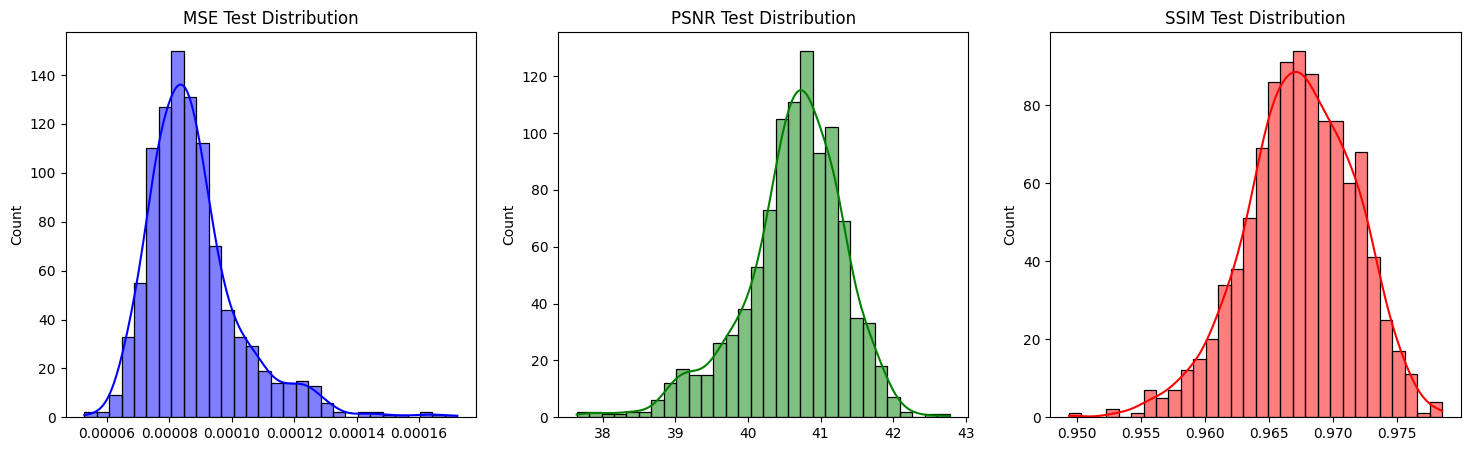

In [24]:
def test_eval():
    mse_list, psnr_list, ssim_list = [], [], []

    for Xtest, ytest in testLoader:
        Xtest = Xtest.to(device)
        yHattest = img_transformer(Xtest).detach().cpu()

        for i in range(ytest.shape[0]):
            orig = ytest[i].squeeze(0).numpy()
            pred = yHattest[i].squeeze(0).numpy()

            mse = mean_squared_error(orig, pred)
            psnr = PSNR(orig, pred)
            ssim = SSIM(orig, pred, data_range=pred.max()-pred.min())

            mse_list.append(mse)
            psnr_list.append(psnr)
            ssim_list.append(ssim)

    mse_list, psnr_list, ssim_list = np.array(mse_list), np.array(psnr_list), np.array(ssim_list)

    return mse_list, psnr_list, ssim_list

mse_list, psnr_list, ssim_list = test_eval()

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

sns.histplot(mse_list, bins=30, kde=True, ax=ax[0], color="blue")
ax[0].set_title("MSE Test Distribution")

sns.histplot(psnr_list, bins=30, kde=True, ax=ax[1], color="green")
ax[1].set_title("PSNR Test Distribution")

sns.histplot(ssim_list, bins=30, kde=True, ax=ax[2], color="red")
ax[2].set_title("SSIM Test Distribution")

plt.show()

### Sample Test Predictions

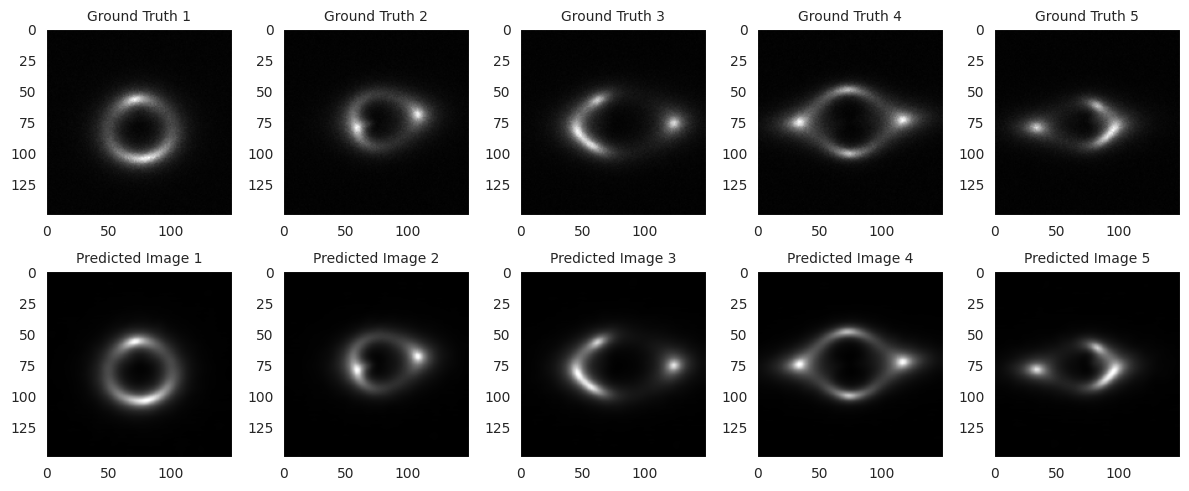

In [25]:
sns.set_style("dark")
fig, ax = plt.subplots(2, 5, figsize=(12, 5))

Xtest, ytest = next(iter(testLoader))
yHattest = img_transformer(Xtest.to(device))

for i in range(5):
    ax[0, i].imshow(ytest[i, :, :, :].squeeze(0).detach(), cmap="gray")
    ax[0, i].set_title(f"Ground Truth {i+1}", fontsize=10)

    ax[1, i].imshow(yHattest[i].squeeze(0).detach().cpu(), cmap="gray")
    ax[1, i].set_title(f"Predicted Image {i+1}", fontsize=10)

plt.tight_layout()
plt.show()